In [1]:
import os
import json
import numpy as np
import random
from collections import Counter, defaultdict
from tqdm import tqdm


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.dpi'] = 300



import torch
import torch.nn as nn
import torch.optim as optim
from models.transformer_new import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Import models

##### Creat Data

In [3]:
SOS_token = 0
EOS_token = 1
pad_idx = 2

class Format:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS", pad_idx: "pad"}
        self.n_words = 3  

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1


def readFile(filename):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(filename, encoding='utf-8').read().strip().split('\n')

    # exclude "IN: "
    pairs = [s[4:].split(' OUT: ') for s in lines]

    input_lang = Format("input")
    output_lang = Format("output")

    return input_lang, output_lang, pairs
  
def prepareData(filename):
    input_lang, output_lang, pairs = readFile(filename)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


# obtain word indices in a sentence
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


# transform to tensor format and add a special token
def tensorFromSentence_input(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    # indexes.insert(0, SOS_token)
    # indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorFromSentence_output(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.insert(0, SOS_token)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# for input and target (one-hot vectors)
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence_input(input_lang, pair[0])
    target_tensor = tensorFromSentence_output(output_lang, pair[1])
    return (input_tensor, target_tensor)


def calculate_mean_std(acc_dict):
    mean = []
    error = []
    keys = sorted(acc_dict[0])
    num_runs = len(acc_dict)
    
    for key in keys:
        t = []
        for d in acc_dict:
            t.append(d[key])
        mean.append(np.mean(t))
        error.append(np.std(t) / np.sqrt(num_runs))
    return np.array(mean), np.array(error), keys


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [4]:
%pwd

'/Users/zhouyuqin/Desktop/ATNLP/transformer_scan'

In [25]:
# input_lang, output_lang, pairs = prepareData("./data/scan/simple_split/tasks_train_simple.txt")
# input_lang_test, output_lang_test, pairs_test = prepareData("./data/scan/simple_split/tasks_test_simple.txt")

input_lang, output_lang, pairs = prepareData("./data/scan/simple_split/size_variations/tasks_train_simple_p64.txt")
input_lang_test, output_lang_test, pairs_test = prepareData("./data/scan/simple_split/size_variations/tasks_test_simple_p64.txt")


# input_lang, output_lang, pairs = prepareData("/Users/zhouyuqin/Desktop/ATNLP/SCAN/add_prim_split/tasks_train_addprim_jump.txt")
# input_lang_test, output_lang_test, pairs_test = prepareData("/Users/zhouyuqin/Desktop/ATNLP/SCAN/add_prim_split/tasks_test_addprim_jump.txt")



# input_lang, output_lang, pairs = prepareData("/Users/zhouyuqin/Desktop/ATNLP/SCAN/length_split/tasks_train_length.txt")
# input_lang_test, output_lang_test, pairs_test = prepareData("/Users/zhouyuqin/Desktop/ATNLP/SCAN/length_split/tasks_test_length.txt")



print(random.choice(pairs))
print(len(pairs), type(pairs))

Reading lines...
Read 13382 sentence pairs
Counting words...
Counted words:
input 16
output 9
Reading lines...
Read 7528 sentence pairs
Counting words...
Counted words:
input 16
output 9
['run opposite left after turn right twice', 'I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_RUN']
13382 <class 'list'>


In [6]:
training_pairs = [tensorsFromPair(pair) for pair in pairs]
test_pairs = [tensorsFromPair(pair) for pair in pairs_test]

In [7]:
len(training_pairs)

16990

##### Hyperparameters

In [8]:
class Lang:
  def __init__(self, num_runs = 1, num_epochs = 20, d_model = 36, nhead = 8, num_decoder_layers = 2, 
               num_encoder_layers = 2,  d_feedforward = 256, learning_rate = 0.0005,
               dropout = 0.1, checkpoint_every = 1, record_loss_every = 2000, clip = 5, teacher_forcing_ratio = 0, batch = 16):
    
    self.num_runs = num_runs
    self.num_epochs = num_epochs
    self.d_model = d_model
    self.nhead = nhead
    self.num_encoder_layers = num_encoder_layers
    self.num_decoder_layers = num_decoder_layers
    self.d_feedforward = d_feedforward
    self.learning_rate = learning_rate
    self.dropout = dropout
    self.checkpoint_every = checkpoint_every
    self.record_loss_every = record_loss_every
    self.clip = clip
    self.teacher_forcing_ratio = teacher_forcing_ratio
    self.batch = batch

In [19]:
args = Lang(d_feedforward = 512, nhead= 6)

In [22]:
model = Seq2Seq(Encoder(input_lang.n_words, 
                    args.nhead * 9, 
                    args.num_encoder_layers, 
                    args.nhead, 
                    args.d_feedforward, 
                    args.dropout, 
                    device), 
                Decoder(output_lang.n_words, 
                        args.nhead * 9, 
                        args.num_decoder_layers, 
                        args.nhead, 
                        args.d_feedforward, 
                        args.dropout, 
                        device), pad_idx, pad_idx, device).to(device)

In [24]:
%pwd

'/Users/zhouyuqin/Desktop/ATNLP/transformer_scan'

##### Test function

In [10]:
def translate_sentence(batch, model, max_len = 50):
    model.eval()
    src = batch[0].T
    src_mask = model.make_src_mask(src)
    with torch.no_grad():
        enc_src = model.encoder(src, src_mask)

    #
    trg_indexes = [SOS_token]
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        output = output[0][i]
        pred_token = output.argmax(0).item()
        trg_indexes.append(pred_token)
        #
        if pred_token == EOS_token:
            break
    return trg_indexes[1:], attention

def test_accuracy(data, model):
    all_correct_trials = 0
    for i, batch in enumerate(data):
        trg = batch[1].T
        trg_out = trg[:,1:] ##[y_1,..., y_2, <EOS>]
        index, _  = translate_sentence(batch, model)

        correct = trg_out[0].tolist() == index
        all_correct_trials += correct
        
        if (i+1)  % 1000 == 0:
            print(i, all_correct_trials/ i)
            
    return all_correct_trials / len(data)

In [11]:
def translate_sentence_ora(batch, model, max_len = 50):
    model.eval()
    src = batch[0].T
    trg = batch[1].T

    src_mask = model.make_src_mask(src)
    with torch.no_grad():
        enc_src = model.encoder(src, src_mask)

    #
    trg_indexes = [SOS_token]
    for i in range(trg.shape[1]-1):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        output = output[0][i]
        _, ind = output.topk(2)
        if ind[0] == 1 and i < trg.shape[1]-2:
            pred_token = ind[1].item()
        
        elif i == trg.shape[1]-2:
            pred_token = 1
        else:
            pred_token = ind[0].item()
        
        trg_indexes.append(pred_token)
        #
    return trg_indexes[1:], attention

def test_accuracy_ora(data, model):
    all_correct_trials = 0
    for i, batch in enumerate(data):
        trg = batch[1].T
        trg_out = trg[:,1:] ##[y_1,..., y_2, <EOS>]
        index, _  = translate_sentence_ora(batch, model)

        correct = trg_out[0].tolist() == index
        all_correct_trials += correct
        
        if (i+1)  % 1000 == 0:
            print(i, all_correct_trials/ i)
            
    return all_correct_trials / len(data)

In [12]:
def test_dic(data, model):
    # length frequency of src
    command_cnt = Counter([len(test_pair[0]) for test_pair in data])
    command_correct_cnt = defaultdict(int)
    
    # length frequency of trg
    action_cnt = Counter([len(test_pair[1]) for test_pair in data])
    action_correct_cnt = defaultdict(int)
    
    model.eval()
    with torch.no_grad():
      all_correct_trials = 0
      for i, batch in enumerate(data):
        trg = batch[1].T
        trg_out = trg[:,1:] ##[y_1,..., y_2, <EOS>]
        index, _  = translate_sentence_ora(batch, model)

        if trg_out[0].tolist() == index:
          command_correct_cnt[len(batch[0])] += 1
          action_correct_cnt[len(batch[1])] += 1
          all_correct_trials += 1
        
        if (i+1)  % 1000 == 0:
            print(i, all_correct_trials/ i)  
    
    accuracy = all_correct_trials / len(data)
    
    ## Calculate accuarcy for src / trg based on length
    command_correct_cnt = dict(command_correct_cnt)
    action_correct_cnt = dict(action_correct_cnt)
    command_cnt = dict(command_cnt)
    action_cnt = dict(action_cnt)
    command_acc = {}

    for command_length, cnt in command_cnt.items():
        command_acc[command_length] = command_correct_cnt.get(
            command_length, 0) / cnt

    action_acc = {}

    for action_length, cnt in action_cnt.items():
        action_acc[action_length] = action_correct_cnt.get(
            action_length, 0) / cnt

    return accuracy, command_acc, action_acc

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

NameError: name 'model' is not defined

### Report results

##### Exp1

In [ ]:
for i in range(5):
    model.load_state_dict(torch.load(f'./results/transformer/len_1_20_0.0005_dyn_te_{i}.pt'))
    accuracy, command_acc, action_acc = test_dic(test_pairs, model)
    command_accs.append(command_acc)
    action_accs.append(action_acc)
    overall_accs.append(accuracy)

In [27]:
# Enter raw data
exp1_1 = np.array([0.0201, 0.01686, 0.0171, 0.01705, 0.01812]) * 100
exp1_2 = np.array([0.1316, 0.03201, 0.04641, 0.03626, 0.03626]) * 100
exp1_4 = np.array([0.06715, 0.08852, 0.0671, 0.1116, 0.1091]) * 100
exp1_8 = np.array([0.05681, 0.09705, 0.07381, 0.06482, 0.04616]) * 100
exp1_16 = np.array([0.1335, 0.05972, 0.09559, 0.1306, 0.05972]) * 100
exp1_32 = np.array([0.112, 0.06752, 0.09987, 0.1608, 0.08875]) * 100
exp1_64= np.array([0.06496, 0.09883, 0.05978, 0.05181, 0.07439]) * 100

In [28]:
# Calculate the average
exp1_1_mean = np.mean(exp1_1)
exp1_2_mean = np.mean(exp1_2)
exp1_4_mean = np.mean(exp1_4)
exp1_8_mean = np.mean(exp1_8)
exp1_16_mean = np.mean(exp1_16)
exp1_32_mean = np.mean(exp1_32)
exp1_64_mean = np.mean(exp1_64)

In [29]:
# Calculate the standard deviation
exp1_1_std = np.std(exp1_1) / np.sqrt(len(exp1_1))
exp1_2_std = np.std(exp1_2) / np.sqrt(len(exp1_1))
exp1_4_std = np.std(exp1_4) / np.sqrt(len(exp1_1))
exp1_8_std = np.std(exp1_8) / np.sqrt(len(exp1_1))
exp1_16_std = np.std(exp1_16) / np.sqrt(len(exp1_1))
exp1_32_std = np.std(exp1_32) / np.sqrt(len(exp1_1))
exp1_64_std = np.std(exp1_64) / np.sqrt(len(exp1_1))

In [30]:
# Create lists for the plot
x_labels = ['1%', '2%', '4%', '8%', '16%', '32%', '64%']
x_pos = np.arange(len(x_labels))
mean = [exp1_1_mean, exp1_2_mean, exp1_4_mean, exp1_8_mean, exp1_16_mean, exp1_32_mean, exp1_64_mean]
error = [exp1_1_std, exp1_2_std, exp1_4_std, exp1_8_std, exp1_16_std, exp1_32_std, exp1_64_std]

Text(0.5, 0, 'Percent of commands used for training')

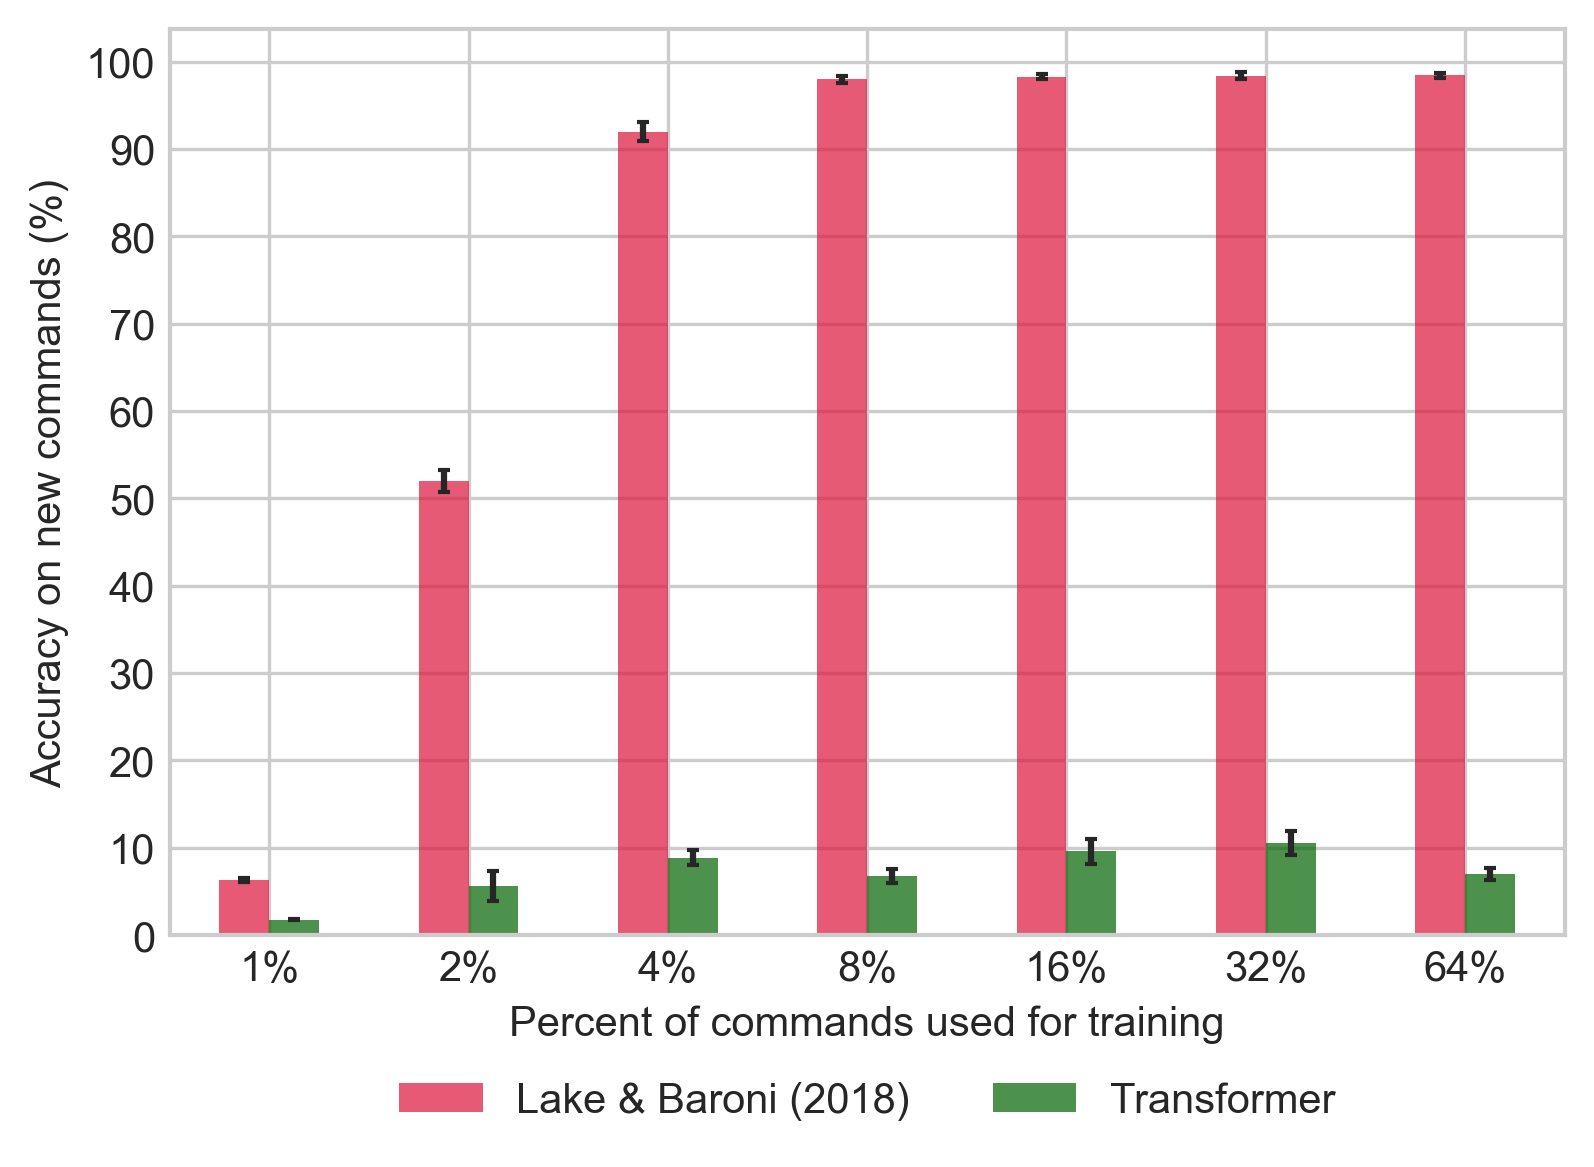

In [31]:
# creating dataframe

df = pd.DataFrame({
    'Name': x_labels,
    'Lake & Baroni (2018)': [6.275, 52, 92, 98, 98.3, 98.4, 98.43],
    'Transformer': mean
})
  
  
# plotting graph
df.plot(x="Name", y=["Lake & Baroni (2018)", "Transformer", ], yerr= [[0.2263, 1.244, 1.113, 0.4254, 0.304, 0.4, 0.28], error], kind="bar",  color=['crimson', 'darkgreen' ], alpha=0.7, capsize = 1.5)
# plt.legend(loc = 'upper left')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True, ncol=5)
plt.xticks(rotation = 0)
plt.yticks(np.arange(0, 101, 10))
plt.ylabel('Accuracy on new commands (%)')
plt.xlabel('Percent of commands used for training')


##### Exp2b

In [99]:
command_accs, action_accs, overall_accs, train_accs = [], [], [], []

In [100]:
for i in range(5):
    model.load_state_dict(torch.load(f'./results/transformer/len_1_20_0.0005_dyn_te_{i}.pt'))
    accuracy, command_acc, action_acc = test_dic(test_pairs, model)
    command_accs.append(command_acc)
    action_accs.append(action_acc)
    overall_accs.append(accuracy)

999 0.5405405405405406
1999 0.5252626313156579
2999 0.5311770590196733
999 0.5375375375375375
1999 0.5207603801900951
2999 0.48782927642547513
999 0.5255255255255256
1999 0.527263631815908
2999 0.5165055018339446
999 0.5895895895895896
1999 0.5502751375687844
2999 0.5421807269089697
999 0.4864864864864865
1999 0.46673336668334164
2999 0.48749583194398133


In [108]:
print(overall_accs)
print(np.mean(overall_accs) * 100)

[0.48801020408163265, 0.4316326530612245, 0.48214285714285715, 0.5015306122448979, 0.44107142857142856]
46.88775510204081


In [105]:
command_mean, command_error, command_keys = calculate_mean_std(command_accs)
action_mean, action_error, action_keys = calculate_mean_std(action_accs)

Text(0.5, 0, 'Command length')

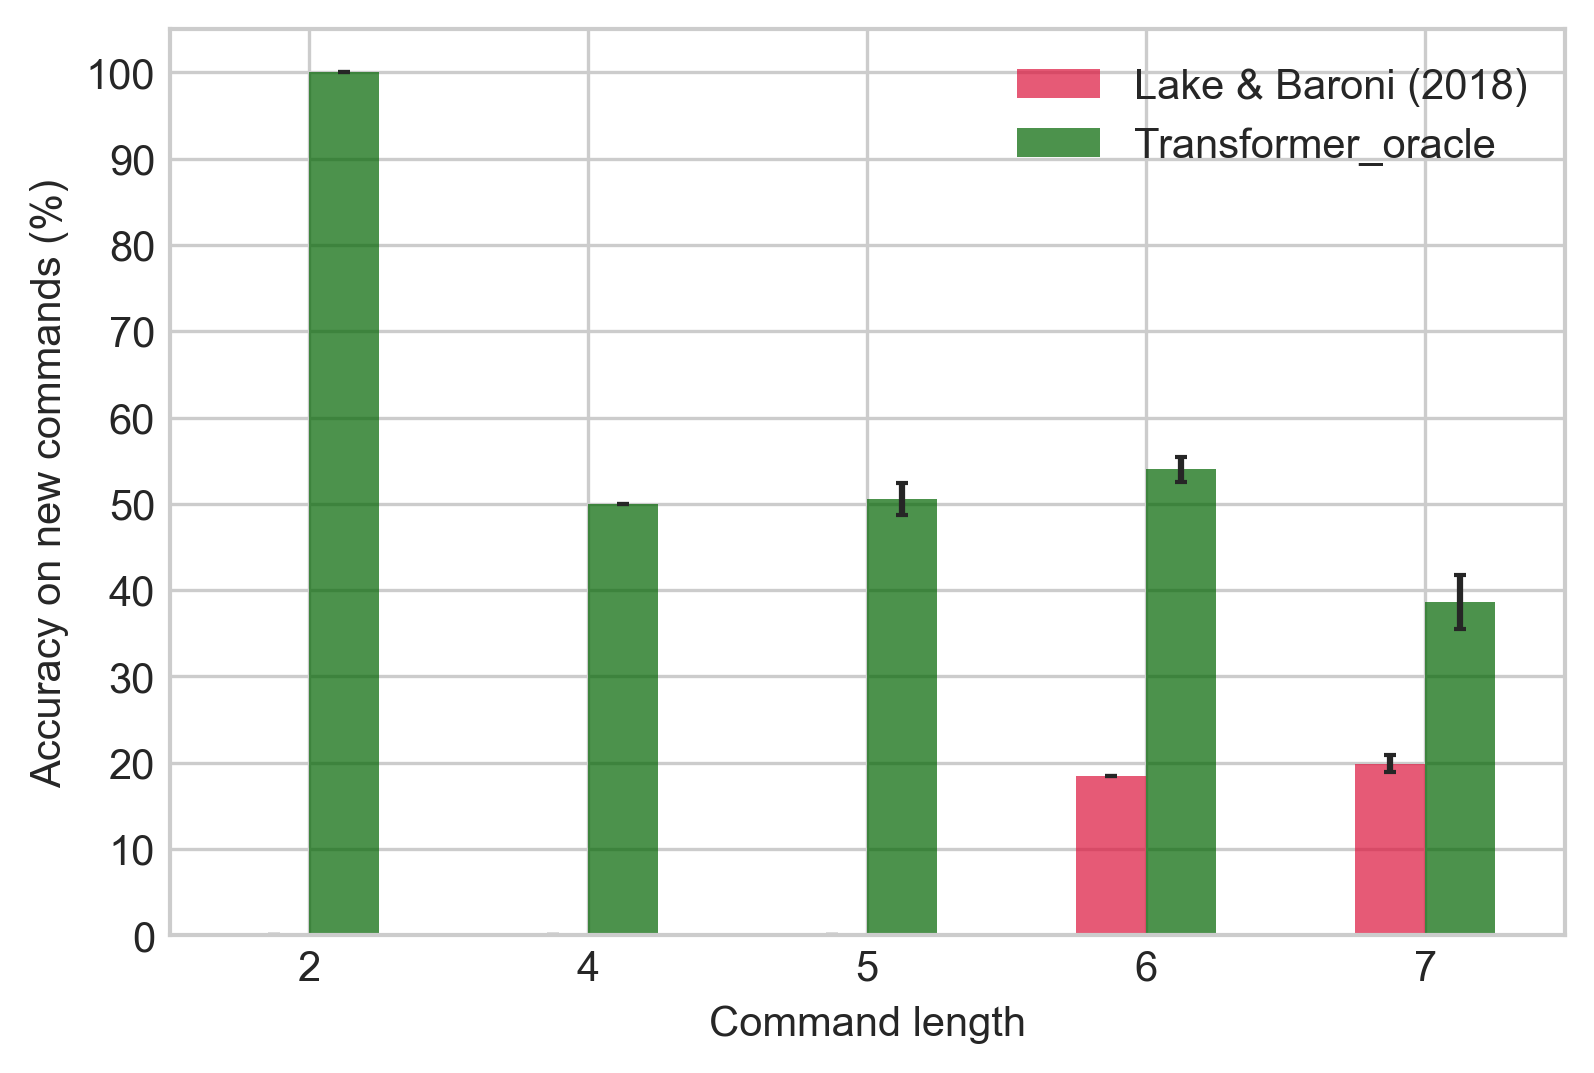

In [106]:
# creating dataframe

df = pd.DataFrame({
    'Name': [command - 2 for command in command_keys] ,
    'Lake & Baroni (2018)': [0, 0, 0, 18.5, 19.9],
    'Transformer_oracle': command_mean * 100
})
  
  
# plotting graph
df.plot(x="Name", y=["Lake & Baroni (2018)", "Transformer_oracle", ], yerr= [[0, 0, 0, 0.01, 1], command_error * 100], kind="bar",  color=['crimson', 'darkgreen' ], alpha=0.7, capsize = 1.5)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
plt.legend(loc = 'upper right')
plt.xticks(rotation = 0)
plt.yticks(np.arange(0, 101, 10))
plt.ylabel('Accuracy on new commands (%)')
plt.xlabel('Command length')


Text(0.5, 0, 'Ground-truth action sequence length')

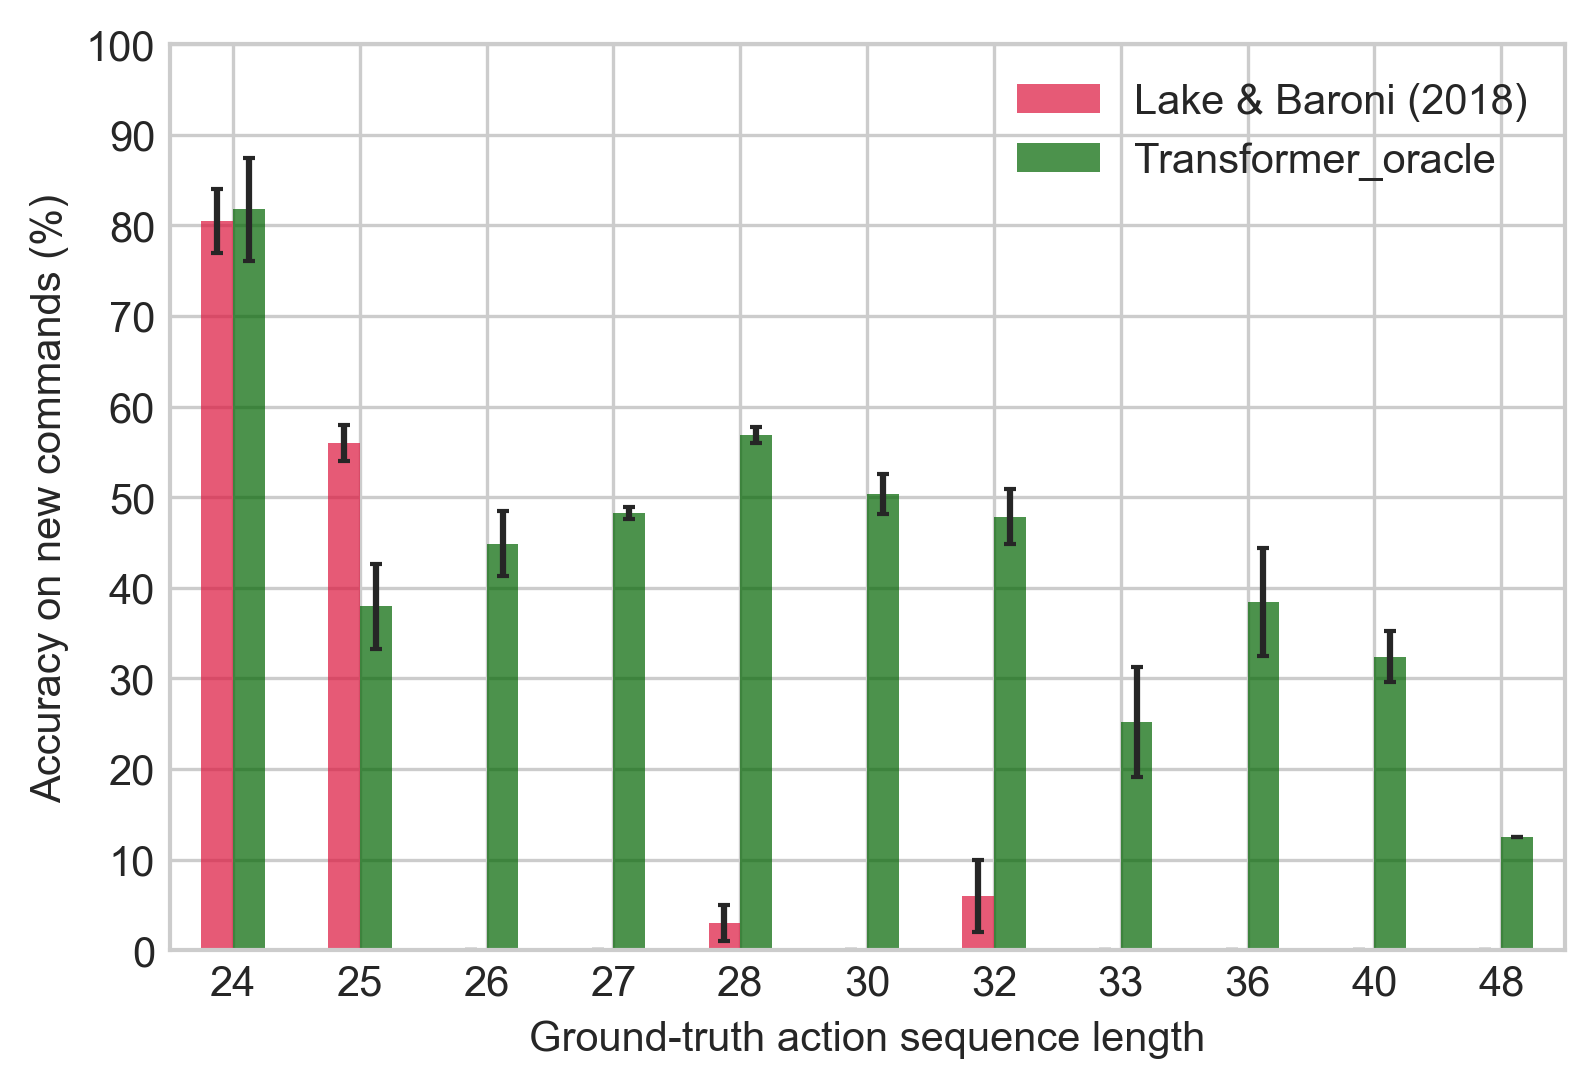

In [107]:
# creating dataframe

df = pd.DataFrame({
    'Name': [action - 2 for action in action_keys],
    'Lake & Baroni (2018)': [80.5, 56, 0, 0, 3, 0, 6, 0, 0, 0, 0],
    'Transformer_oracle': action_mean * 100
})
  
  
# plotting graph
df.plot(x="Name", y=["Lake & Baroni (2018)", "Transformer_oracle", ], yerr= [[3.5, 2, 0, 0, 2, 0, 4, 0, 0, 0, 0], action_error * 100], kind="bar",  color=['crimson', 'darkgreen' ], alpha=0.7, capsize = 1.5)
plt.legend(loc = 'upper right')
plt.xticks(rotation = 0)
plt.yticks(np.arange(0, 101, 10))
plt.ylabel('Accuracy on new commands (%)')
plt.xlabel('Ground-truth action sequence length')
